In [1]:
import mandalka
import matplotlib.pyplot as plt
import numpy as np
import sys

from agents import *
from worlds import *
from values import *

Some utilities to visualize performance:

In [2]:
@mandalka.node
class Score:
    def __init__(self, world, agent):
        rew_sum = 0.0
        for _ in range(2):
            for t in world.trajectory_batch(agent, range(16)):
                for o, a, r in t:
                    rew_sum += np.mean(r)
        self.get = lambda: rew_sum / 32.0

In [3]:
def histogram(Agent, learn_world, test_world, n=20):
    if isinstance(learn_world, CachedExperience):
        print("Trajectories in experience cache:", len(learn_world))
    agents = mandalka.threads([Agent(learn_world, i) for i in range(n)])
    scores = mandalka.threads([Score(test_world, a) for a in agents])
    plt.hist([s.get() for s in scores], range=(0, 100))
    plt.show()

Build a simple (and fast) reinforce learning agent:

In [4]:
SupervisedAgent = Softmax(
    logits=BasicNet(
        hidden_layers=[32],
        batch_size=16,
        params=GradAscent(n_steps=8, log_lr=0.9, init=Gauss)
    )
)
RLAgent = WholeTrajectories(
    agent=Reinforce(policy=SupervisedAgent)
)

First, let's try "normal" learning on the original CartPole environment:

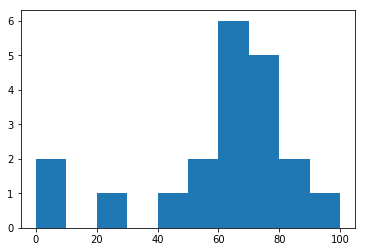

In [14]:
histogram(
    RLAgent,
    learn_world=Gym("CartPole-v1"),
    test_world=Gym("CartPole-v1")
)

It worked!

Now, let's teach the same agent on cached episodes, which we gather by running a random agent:

Trajectories in experience cache: 1000


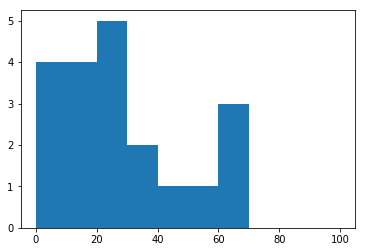

In [15]:
histogram(
    RLAgent,
    learn_world=CachedExperience(
        Gym("CartPole-v1"),
        agents=RandomChoice(p=0.5),
        seed=123,
        test_each=1000
    ),
    test_world=Gym("CartPole-v1")
)

The performance dropped significantly, but it's still learning (at least in some of the attempts).

For comparison, this is the performance of the random agent itself:

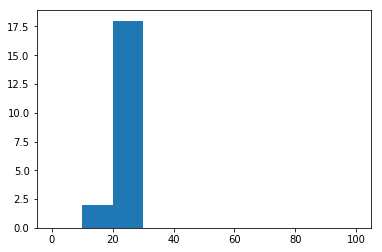

In [17]:
histogram(
    RandomChoice(p=0.5),
    learn_world=Gym("CartPole-v1"),
    test_world=Gym("CartPole-v1")
)

Can it learn from even lower quality data, gathered by a deterministic agent which chooses "left" and "right" actions in turn?

Trajectories in experience cache: 1000


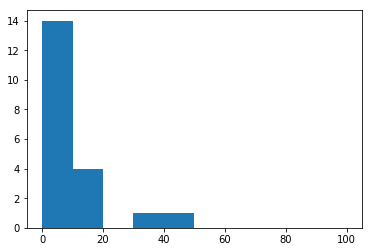

In [18]:
histogram(
    RLAgent,
    learn_world=CachedExperience(
        Gym("CartPole-v1"),
        agents=Cycle(sequence=[[0, 1], [1, 0]]),
        seed=123,
        test_each=1000
    ),
    test_world=Gym("CartPole-v1")
)

No, in this case the performance was worse than the random agent...

OK, what about learning from experience gathered by another reinforcement learner, while it is learning on the same environment?

Trajectories in experience cache: 970


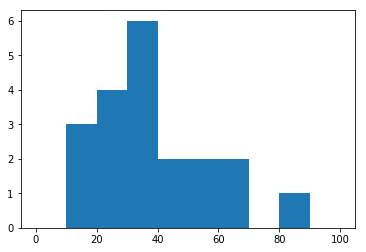

In [19]:
histogram(
    RLAgent,
    learn_world=CachedExperience(
        Gym("CartPole-v1"),
        agents=[RLAgent] * 5,
        seed=123,
        test_each=50
    ),
    test_world=Gym("CartPole-v1")
)

In [20]:
StrongSupervisedAgent = Softmax(
    logits=BasicNet(
        hidden_layers=[32],
        batch_size=16,
        params=GradAscent(n_steps=30, log_lr=0.9, init=Gauss)
    )
)
StrongRLAgent = WholeTrajectories(
    agent=Reinforce(policy=StrongSupervisedAgent)
)

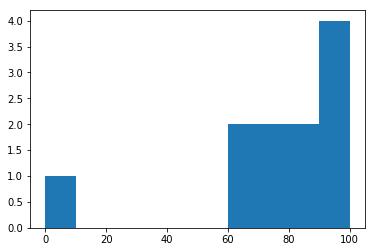

In [21]:
histogram(
    StrongRLAgent,
    learn_world=Gym("CartPole-v1"),
    test_world=Gym("CartPole-v1")
)

Trajectories in experience cache: 2730


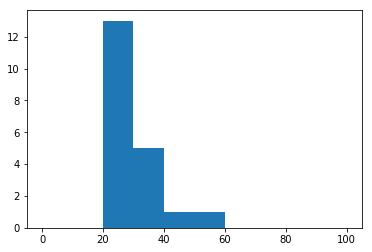

In [22]:
histogram(
    RLAgent,
    learn_world=CachedExperience(
        Gym("CartPole-v1"),
        agents=[StrongRLAgent] * 5,
        seed=123,
        test_each=50
    ),
    test_world=Gym("CartPole-v1")
)

Ups! Not really? It seems to have gone over our agent's head.

What about the reverse: train a stronger agent on learning experience of the weaker agent?

Trajectories in experience cache: 970


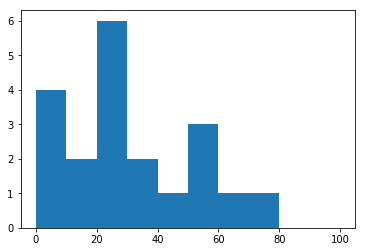

In [25]:
histogram(
    StrongRLAgent,
    learn_world=CachedExperience(
        Gym("CartPole-v1"),
        agents=[RLAgent] * 5,
        seed=123,
        test_each=50
    ),
    test_world=Gym("CartPole-v1")
)

That's not perfect, but better than the converse...